---

# <span style="color:red">  Usage de la complexité de Kolmogorov pour détecter les visages similaires

----

#### Complexité de Kolmogorov

La théorie de l'information algorithmique repose sur un principe simple défini par Kolmogorov : la complexité de Kolmogorov d'un objet - nombre, image numérique chaîne de chactères - est la taille du plus petit algorythme (dans un certain language de programmation fixé) qui engendre cet objet.


Considérons une machine informatique M pouvant exécuter des programmes. On dit que cette machine est universelle lorsqu’elle peut émuler n'importe quelle autre machine informatique. La machine de Turing universelle en est un exemple.

On note PM l'ensemble des programmes écrits pour la machine M. Pour un programme p ∈ PM, on note l(p) sa longueur en nombre d’instructions pour la machine M et s(p) sa sortie. La complexité de Kolmogorov KM(x), ou complexité algorithmique, d’une suite x finie de caractères pour une machine M est déﬁnie par :

$$
K_M(x) = \min_{p \in P_M} \{ l(p) , s(p) = x \}
$$

Dans notre cas, nous nous intérressons à la compléxité conditionnelle K(x1|x2) entre deux images.

$$
K_M(x_1|x_2) = \min_{p \in P_M}\{ l(p), s(x2,p) = x1 \}
$$

Bin que la complexité de Kolmogorov soit incalculable il a été demontré que nous pouvons raisonnablement l'approché par le nombre de bits nécessaires pour coder x à l'aide d'un compresseur C (par exemple gzip, izma ...) i.e. :

$$
K(x) \approx C(x)
$$

#### Mesure de similarité par l'approximation de la compléxité de Kolmogorov

Nous avons défini la compléxité de Kolmogorov comme la messure du contenu en information algorythmique d'un objet.
Nos pouvons l'utiliser pour estimer une mesure de similarité entre deux objets. Soit calculer la distance d'information normalisé (NID) : 

$$
NID(x,y) = \frac{\max\{K(x|y), K(y|x) \}}{\max\{K(x),K(y) \}} = \frac{K(x,y) - min(K(x), K(y))}{\max(K(x),K(y))}
$$


où, $K(x,y)$ : complexité de la concaténation de x et y.

Cependant cette métric n'est pas calculable.



---
Apparté : 

La distance d'information est absolue, mais si nous voulons exprimer la similarité, nous sommes plus intéressés par les distances relatives. Par exemple, si deux chaînes de longueur 1 000 000 diffèrent de 1000 bits, nous considérons que ces chaînes sont relativement plus similaires que deux chaînes de 1000 bits qui diffèrent de 1000 bits. Il faut donc normaliser pour obtenir une métrique de similarité. De cette façon, on obtient la distance d'information normalisée (NID).

---

Comme NID n'est toujours pas calculable, nous pouvons utiliser son approximation par compréssion, afin d'obtenir la distance de compréssion normalisé (NCD), ***réécriture de NID par Vitanyi et Cilibrasi*** :

$$
NCD(x,y) = \frac{C(x,y) - min(C(x), C(y))}{\max(C(x),C(y))}
$$

La NCD est en fait une famille de distances paramétrées par le compresseur C. Plus C est bon, plus la NCD se rapproche de la NID, et meilleurs sont les résultats. 

$C(x,y)$ est içi la taille de l'image concaténé.

#### Reconnaissance de visage avec l'utilisation de NCD

L'objectif est d'appliquer la distance de compression normalisée (NCD) à une base de donnée de visage. 

Voici une liste de telles bases de données : http://web.mit.edu/emeyers/www/face_databases.html

Nous utiliserons the Yale Face Database. (The Yale Face Database (size 6.4MB) contains 165 grayscale images in GIF format of 15 individuals. There are 11 images per subject, one per different facial expression or configuration: center-light, w/glasses, happy, left-light, w/no glasses, normal, right-light, sad, sleepy, surprised, and wink.)



De plus pour calculer la distance nous avons besoin de choisir des compresseurs. 

Pour commencer nous allons utiliser quelques-uns des plus courent :
- jpeg
- png
- gzip
- Izma (7-Zip)

In [1]:
# accès rapide aux données contenues dans une image
from PIL import Image
from io import BytesIO

import numpy as np
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
import pandas as pd


from functools import partial

import matplotlib.pyplot as plt


# Import des library de compression
import gzip
import lzma
import zlib

In [2]:
############################################
############# Fonctions utiles #############
############################################

# Pour compresser en jpeg2000, jpeg, png
# La forme des library déjà écrite en python le son sous la forme ci-dessous.
# Nous respectont la mise en forme pour faciliter l'usage.
# exemple pour gzip : gzip.compress(img)

class jpeg:
    def compress(img):
        buffer = BytesIO()
        img.save(buffer, "JPEG")
        # Python file method seek() sets the file's current position at the offset.
        buffer.seek(0)
        return buffer.read()

class png:
    def compress(img):
        buffer = BytesIO()
        img.save(buffer, "PNG")
        # Python file method seek() sets the file's current position at the offset.
        buffer.seek(0)
        return buffer.read()
          
# Charge les images en array
def load_images(img1_path, img2_path):
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)
    return img1, img2

# Concatene deux images verticalement => https://note.nkmk.me/en/python-pillow-concat-images/
def concat_images_v(img1, img2):
    # Pour choisir le mode: https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
    # 'L' : (8-bit pixels, black and white)
    img_v = Image.new('L', (img1.width, img1.height + img2.height)) 
    img_v.paste(img1, (0, 0))
    img_v.paste(img2, (0, img1.height))
    return img_v

# Lzma, gzip and zlib on besoin que les images soient converties en bytes.
def transform_bytes(img1, img2, concate_img):
    img1 = img1.tobytes()
    img2 = img2.tobytes()
    concate_img = concate_img.tobytes()
    return img1, img2, concate_img

##############################
#### Choix du compresseur ####
##############################

def given_comp(img1_path, img2_path, choose_compressor = 'gzip'):

    img1, img2 = load_images(img1_path, img2_path)

    concate_img = concat_images_v(img1, img2)

    if choose_compressor in [lzma, gzip, zlib]:
        # Besoin de transformer les images en bytes
        img1, img2, concate_img = transform_bytes(img1, img2, concate_img)

    img1_comp = choose_compressor.compress(img1)
    img2_comp = choose_compressor.compress(img2)
    concate_comp = choose_compressor.compress(concate_img)

    return concate_comp, img1_comp, img2_comp

########################
#### Formule du NCD ####
########################

def ncd_dist(concate_comp, img1_comp, img2_comp):
    return (len(concate_comp) - min(len(img1_comp), len(img2_comp))) / (max(len(img1_comp), len(img2_comp)))


######################################
### Return Dist NCD de deux images ###
######################################

def return_NCD(img1_path, img2_path, choose_compressor, text=False):
    
    concate_comp, img1_comp, img2_comp = given_comp(img1_path, img2_path, choose_compressor)
    
    value = ncd_dist(concate_comp, img1_comp, img2_comp)

    if text:
        print("Value Compression img1 : C(img1_comp) = ", len(img1_comp))
        print("Value Compression img2 : C(img2_comp) = ", len(img2_comp))
        print("Value Compression concatenation : C(concate_comp) = ", len(concate_comp))

    return value

In [3]:
img1_path = 'yalefaces/subject02.glasses'
img2_path = 'yalefaces/subject03.happy'

In [4]:
img1, img2 = load_images(img1_path, img2_path)

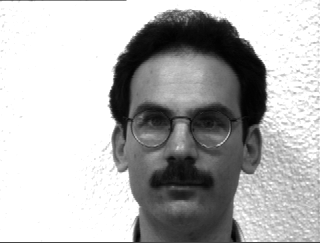

In [5]:
img1


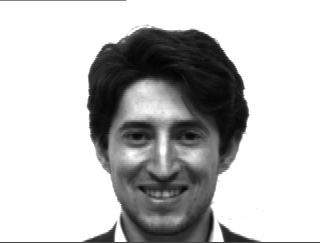

In [6]:
img2

In [7]:
return_NCD(img1_path, img2_path, choose_compressor = gzip, text=True)

Value Compression img1 : C(img1_comp) =  38963
Value Compression img2 : C(img2_comp) =  24136
Value Compression concatenation : C(concate_comp) =  62973


0.9967661627698072

Nous avons donc réer une metrique à l'aide de Kolmogorov. Pour voir si cette nouvelles metrique fonctionne correctement nous allons l'utiliser avec un KNN.

Nous pouvons assigner un nom à chacune des différentes faces de nos visages.

In [8]:
# Liste du nom de toutes les images
images = glob.glob('yalefaces/*')
# Liste des labels de chaque images
labels = [x.split('/')[-1].split('.')[0] for x in images]
# Crée la liste des indices de chaque image
indices = np.arange(len(labels))

In [9]:
images[0:6]

['yalefaces/subject04.leftlight',
 'yalefaces/subject01.wink',
 'yalefaces/subject06.surprised',
 'yalefaces/subject07.glasses',
 'yalefaces/subject15.rightlight',
 'yalefaces/subject12.surprised']

In [10]:
labels[0:6]

['subject04', 'subject01', 'subject06', 'subject07', 'subject15', 'subject12']

In [11]:
indices[0:6]

array([0, 1, 2, 3, 4, 5])

In [12]:
def custom_dist_sklearn(a,b, choose_compressor='gzip'):
    """
    Adapter le calcul de la distance pour KNN
    """
    global images
    
    comp_map = {'gzip': partial(return_NCD,choose_compressor=gzip), 'lzma': partial(return_NCD,choose_compressor=lzma), 
                'jpeg': partial(return_NCD,choose_compressor=jpeg),
                'png': partial(return_NCD,choose_compressor=png),
                }
            
    img1_path = images[int(a)]
    img2_path = images[int(b)]
    return comp_map[choose_compressor](img1_path, img2_path)

In [13]:
# Methode de validation croisée d'un contre tous LOOCV
loo = LeaveOneOut()

In [14]:
clf_gzip = KNeighborsClassifier(n_neighbors=3, algorithm="brute", metric=custom_dist_sklearn, metric_params={'choose_compressor':'gzip'})
clf_lzma = KNeighborsClassifier(n_neighbors=3, algorithm="brute", metric=custom_dist_sklearn, metric_params={'choose_compressor':'lzma'})
clf_jpeg = KNeighborsClassifier(n_neighbors=3, algorithm="brute", metric=custom_dist_sklearn, metric_params={'choose_compressor':'jpeg'})
clf_png = KNeighborsClassifier(n_neighbors=3, algorithm="brute", metric=custom_dist_sklearn, metric_params={'choose_compressor':'png'})

In [22]:
scores_gzip = cross_val_score(clf_gzip, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo)
scores_lzma = cross_val_score(clf_lzma, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo)
scores_jpeg = cross_val_score(clf_jpeg, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo)
scores_png = cross_val_score(clf_png, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo)

In [23]:
d = [ ["gzip", np.mean(scores_gzip)],
     ["lzma", np.mean(scores_lzma)],
     ["jpeg", np.mean(scores_jpeg)],
     ["png", np.mean(scores_png)]]

df = pd.DataFrame(d, columns = ['Méthode de compression','Valeur du score moyen'])
print(df)

  Méthode de compression  Valeur du score moyen
0                   gzip               0.078313
1                   lzma               0.427711
2                   jpeg               0.066265
3                    png               0.024096


Comme nous pouvons le constater, les résultats ne sont pas ceux escomptés. La raison principale est que ces compresseurs ne sont pas normaux. La normalité est nécessaire pour qu'un compresseur soit efficace dans le calcul de la distance NCD. Une condition importante pour qu'un compresseur soit normal est que C(x,x)=C(x), c'est-à-dire que la longueur de compression de la concaténation de la même image doit être égale à la longueur de compression de l'image elle-même.  

In [24]:
value_lzma = return_NCD(img1_path, img1_path, lzma, text=False)
value_gzip = return_NCD(img1_path, img1_path, gzip, text=False)
value_jpeg = return_NCD(img1_path, img1_path, jpeg, text=False)
value_png = return_NCD(img1_path, img1_path, png, text=False)

In [25]:
d_xx = [ ["lzma C(x,x)", value_lzma],
     ["gzip C(x,x)", value_gzip],
     ["jpeg C(x,x)", value_jpeg],
     ["png C(x,x)", value_png]]

df_xx = pd.DataFrame(d_xx, columns = ['Valeur C(x,x) pour les diff compr','Valeur (plus faible = plus normalisé)'])
print(df_xx)

  Valeur C(x,x) pour les diff compr  Valeur (plus faible = plus normalisé)
0                       lzma C(x,x)                               0.003122
1                       gzip C(x,x)                               0.998332
2                       jpeg C(x,x)                               0.977468
3                        png C(x,x)                               0.994744


Ci-dessus quelques résultats de calcul de C(x,x). Le seul compresseur qui est normalisé est lzma.

Pourtant, ces résultats sont encore encourageants car la clé de l'approximation de la complexité de Kolmogorov et de la distance NID semble se trouver dans le choix du compresseur.

Pour verifier l'hypothése nous allons tester deux types de compresseur vidéo:
- mpeg1 : MPEG-1 est une norme de compression vidéo et audio définie par la norme ISO/CEI-11172, élaborée par le groupe MPEG en 1988. Ce groupe a pour but de développer des standards internationaux de compression, décompression, traitement et codage d'images animées et de données audio.


- h264 : encodeur de youtube à la particularité d'encoder également encoder la rotation, le zoom, l'inclinaison, le panoramique, l'étirement, la déformation, etc.

Ces deux compresseur sont basé sur une format video et non plus sur la concaténation de deux images.
Pour résoudre se problème Campana & Keogh, **(B. J. L. Campana and E. J. Keogh, “A compression-based distance measure for texture,”Statistical Analysis and Data Mining, vol. 3,no. 6, 2010.)** on dévellopé une nouvelle métrique de similarité d'image CK-1. 

$$
CK1(x,y) = \frac{C(x|y) + C(y|x)}{C(x|x) + C(y|y)} - 1
$$

Le but est de permettre de calculer la redondante spacial et temporelle entre deux images.
C(x|y) est calculé à l'aide du compresseur vidéo MPEG-1, où les images x et y constituent une vidéo à deux images. Si x et y sont similaires, leur compression inter-image doit être élevée, ce qui donne une vidéo compressée plus petite.


La library Python **ffmpeg** permet de faire cela.

In [19]:
import ffmpeg
# https://kkroening.github.io/ffmpeg-python/ doc

from collections import Counter

In [21]:
###################################
######## Video Compression ########
###################################

def video_compression(img1_path, img2_path, choose_compressor):
    input_1 = ffmpeg.input(img1_path) #, format='image2', vcodec='gif')
    input_2 = ffmpeg.input(img2_path) #, format='image2', vcodec='gif')
    imgs = ffmpeg.concat(input_1, input_2)
    
    stream = imgs.output('pipe:', format='rawvideo', vcodec=choose_compressor)
    stream = stream.global_args( '-loglevel', 'error').run_async(pipe_stdout=True)
    compression = stream.stdout.read()

    return len(compression)

###################################
########## Distance  CK1 ##########
###################################

def ck1_dist(img1_path, img2_path, choose_compressor):
    C_xy = video_compression(img1_path, img2_path, choose_compressor)
    C_yx = video_compression(img2_path, img1_path, choose_compressor)
    C_xx = video_compression(img1_path, img1_path, choose_compressor)
    C_yy = video_compression(img2_path, img2_path, choose_compressor)

    return (C_xy + C_yx) / (C_xx + C_yy) - 1

In [ ]:
def custom_dist_sklearn(a,b, choose_compressor='gzip'):
    """
    Adapter le calcul de la distance pour KNN
    """
    global images
    
    comp_map = {'gzip': partial(return_NCD,choose_compressor=gzip), 'lzma': partial(return_NCD,choose_compressor=lzma), 
                'jpeg': partial(return_NCD,choose_compressor=jpeg),
                'png': partial(return_NCD,choose_compressor=png),
                # Ajout de la compression video
                'mpeg4' : partial(ck1_dist, choose_compressor='mpeg4'), 'h264' : partial(ck1_dist, choose_compressor='h264')
                }
            
    img1_path = images[int(a)]
    img2_path = images[int(b)]
    return comp_map[choose_compressor](img1_path, img2_path)

In [28]:
ck1_dist(img1_path, img2_path, choose_compressor='mpeg4')

0.9365040451090954

In [46]:
clf_mpeg4 = KNeighborsClassifier(n_neighbors=3, algorithm="brute", metric=custom_dist_sklearn, metric_params={'choose_compressor':'mpeg4'})

In [ ]:
scores_mpeg4 = cross_val_score(clf_mpeg4, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo, n_jobs=-1)

In [51]:
print('Le resultat de la distance CK1 pour le compresseur mpeg4 est : ', np.mean(scores_mpeg4))

Le resultat de la distance CK1 pour le compresseur mpeg4 est :  0.8614457831325302


In [48]:
clf_h264 = KNeighborsClassifier(n_neighbors=3, algorithm="brute", metric=custom_dist_sklearn, metric_params={'choose_compressor':'h264'})

In [48]:
scores_h264 = cross_val_score(clf_h264, indices.reshape(-1, 1), labels, scoring='accuracy', cv=loo, n_jobs=-1)

In [50]:
print('Le resultat de la distance CK1 pour le compresseur h264 est : ', np.mean(scores_h264))

Le resultat de la distance CK1 pour le compresseur h264 est :  0.7891566265060241


In [72]:
################################################################################################
##### Fait les predictions pour une image et affiche les n = 10 plus proches photos trouvé #####
################################################################################################

def predict_and_plot(clf, indices, labels, test, images = images):
    
    Xtrain = np.delete(indices, test)
    ytrain = np.delete(labels, test)
    
    clf.fit(Xtrain.reshape(-1, 1), ytrain)
    
    d, l = clf.kneighbors([[test]], n_neighbors=10, return_distance=True)
    nn = Xtrain[l].ravel()
    d = d.ravel()
    
    fig, axs = plt.subplots(2,5, figsize=(15, 5))
    axs = axs.ravel()
    
    img = Image.open(images[test]).convert('RGB')
    axs[0].imshow(img)
    axs[0].title.set_text('Image original')
    axs[0].set_xticks([]) 
    axs[0].set_yticks([]) 

    enumerer = enumerate(Xtrain[l].ravel()[:-1])
    
    for i,k in enumerer:
        img = Image.open(images[k]).convert('RGB')
        axs[i+1].imshow(img)
        axs[i+1].title.set_text('Vs n°{}, d={}'.format(i+1, round(d[i], 4)))
    
    labels = np.array(labels)
    preds = labels[nn[:clf.get_params()['n_neighbors']]]
    # https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/
    occurence_count = Counter(preds.flat)
    pred = occurence_count.most_common(1)[0][0]
    
    print('Individu cible: {}'.format(labels[test]))
    print('Individu prédit: %s'%pred)

Individu cible: subject04
Individu prédit: subject01


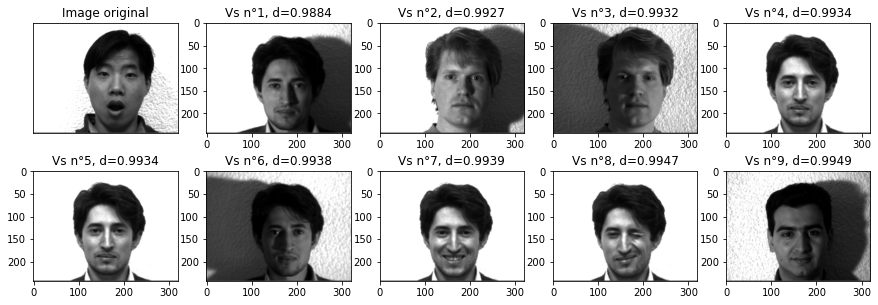

In [73]:
predict_and_plot(clf = clf_gzip, indices = indices, labels = labels, test = 78) 

Individu cible: subject04
Individu prédit: subject13


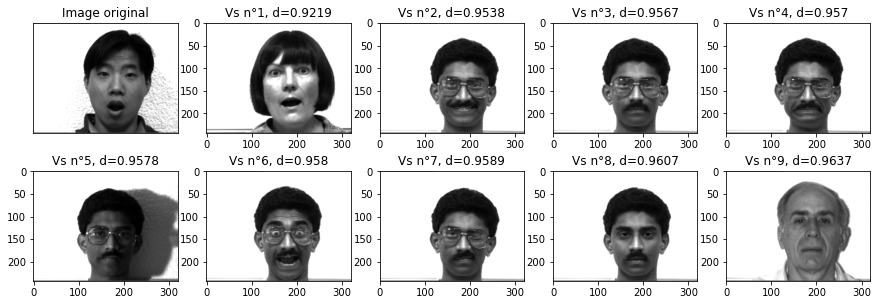

In [74]:
predict_and_plot(clf = clf_jpeg, indices = indices, labels = labels, test = 78)

Individu cible: subject04
Individu prédit: subject10


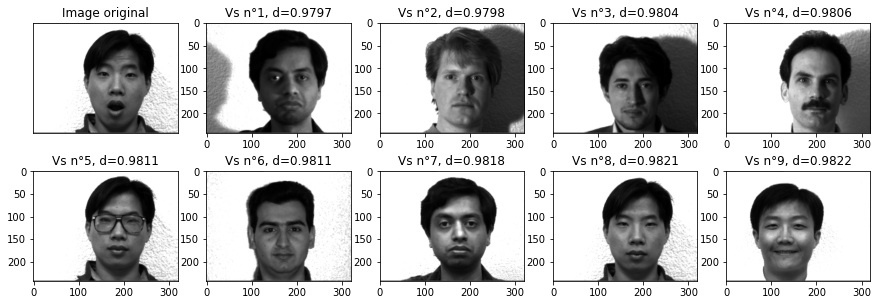

In [75]:
predict_and_plot(clf = clf_lzma, indices = indices, labels = labels, test = 78)

Individu cible: subject04
Individu prédit: subject06


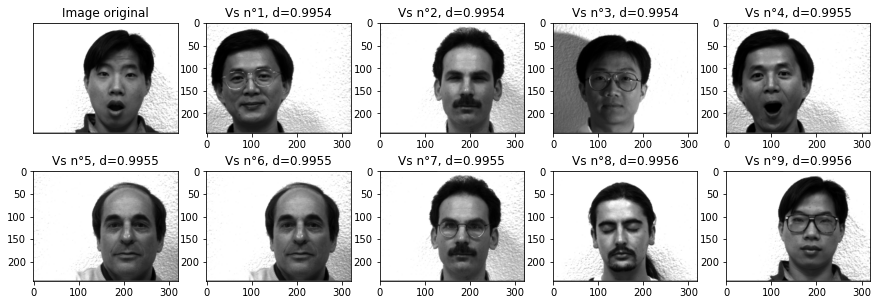

In [76]:
predict_and_plot(clf = clf_png, indices = indices, labels = labels, test = 78)

Individu cible: subject04
Individu prédit: subject04


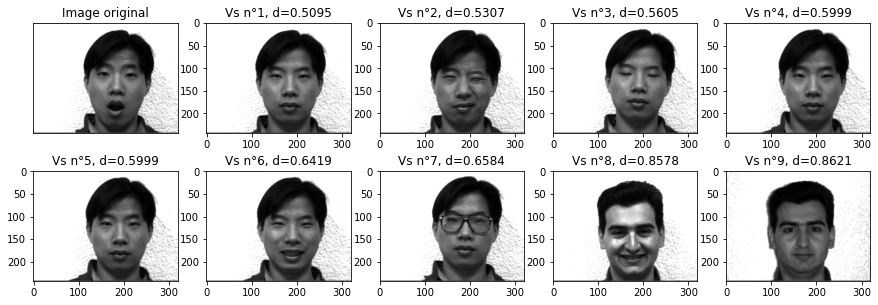

In [77]:
predict_and_plot(clf = clf_mpeg4, indices = indices, labels = labels, test = 78)

Individu cible: subject04
Individu prédit: subject04


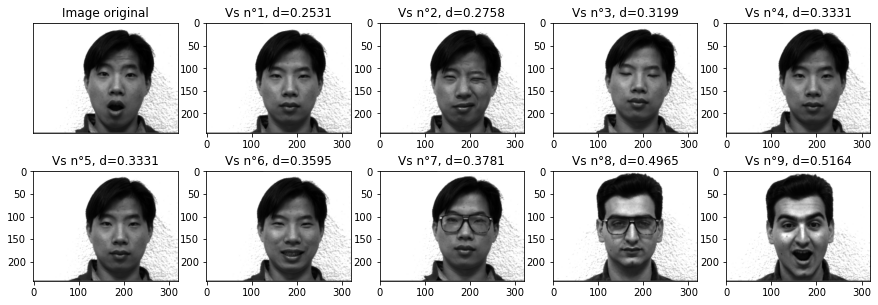

In [78]:
predict_and_plot(clf = clf_h264, indices = indices, labels = labels, test = 78)